In [170]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.4f}'.format})

In [171]:
import numpy as np

# Pauli matrices
σx = np.array([[0, 1],
               [1, 0]], dtype=complex)
σy = np.array([[0, -1j],
               [1j, 0]], dtype=complex)

def winding_number_generic(Hk, Nk=2000):
    """
    Compute the 1D winding number of a chiral (σx,σy) model H(k),
    by discretizing k in [-π,π).

    Parameters
    ----------
    Hk : function
        Callable Hk(k) returning a 2×2 complex ndarray at momentum k.
    Nk : int
        Number of k‑points (higher = more accurate).

    Returns
    -------
    ν : int
        The winding number.
    """
    # sample k
    ks = np.linspace(-np.pi, np.pi, Nk, endpoint=False)
    # preallocate angle array
    phis = np.empty(Nk, dtype=float)

    for i, k in enumerate(ks):
        H = Hk(k)
        # project onto σx, σy
        hx = 0.5 * np.trace(H @ σz).real
        hy = 0.5 * np.trace(H @ σy).real
        phis[i] = np.arctan2(hy, hx)

    # unwrap the phase to remove 2π jumps
    phis_un = np.unwrap(phis)
    # finite differences
    dphi = np.diff(phis_un)
    # total change
    Δφ = np.sum(dphi)
    # winding = Δφ/(2π), rounded to nearest integer
    return int(np.rint(Δφ / (2*np.pi)))



In [172]:
# Helper function to implement periodic boundary conditions:
def pbc(n, N):
    return n % N


def H_real_ladder(omega_c,omega_q, g_Φ,g_c,g_q, N=100):
    
    
    # Total Hilbert space dimension: 2 modes per cell
    dim = 2 * N
    
    # Initialize the Hamiltonian matrix (complex valued)
    H_real = np.zeros((dim, dim), dtype=np.complex128)
    
    # Loop over unit cells to build H_real
    for n in range(N):
        # Basis ordering: index 2*n for mode a, index 2*n+1 for mode b at cell n.
        idx_a = 2 * n      # mode a in cell n
        idx_b = 2 * n + 1  # mode b in cell n
    
        # Onsite terms
        H_real[idx_a, idx_a] += omega_c
        H_real[idx_b, idx_b] += omega_q
    
        # Intra-cell (onsite) coupling between a and b (and its Hermitian conjugate)
        H_real[idx_a, idx_b] += g_Φ
        H_real[idx_b, idx_a] += g_Φ
    
        # Inter-cell couplings: couple cell n with cell n+1 (with periodic BC)
        # Determine indices for cell n+1 using periodic boundary conditions:
        n_next = pbc(n + 1, N)
        idx_a_next = 2 * n_next      # a in cell n+1
        idx_b_next = 2 * n_next      + 1  # b in cell n+1
    
        if n==N-1:
            continue
        # Coupling between adjacent a modes (resonators): g_c (real, + sign)
        H_real[idx_a, idx_a_next] += g_c
        H_real[idx_a_next, idx_a] += g_c
    
        # Coupling between adjacent b modes (qubits): g_q (real, - sign)
        H_real[idx_b, idx_b_next] += -g_q
        H_real[idx_b_next, idx_b] += -g_q
    
        # Cross-coupling: from b in cell n to a in cell n+1: -np.sqrt(g_c * g_q) 
        H_real[idx_b, idx_a_next] += -np.sqrt(g_c * g_q) 
        H_real[idx_a_next, idx_b] += -np.sqrt(g_c * g_q) 
    
        # Cross-coupling: from a in cell n to b in cell n+1: +np.sqrt(g_c * g_q) 
        H_real[idx_a, idx_b_next] += np.sqrt(g_c * g_q) 
        H_real[idx_b_next, idx_a] += np.sqrt(g_c * g_q) 

    return H_real

In [173]:
cases = []

#Flat bands 
δ   = 0
g_Φ = 1 # can be any?
g_c = 1 # can be any        
g_q = g_c 
E_flat_bands = np.sqrt(g_Φ**2 + (g_c + g_q)**2 )
cases.append([δ, g_Φ, g_c, g_q])


#Dirac point at +- pi
g_Φ = 0 
g_q = 1   # can be any
g_c = 1   # can be any
δ   = 2 * (g_q+g_c) 
cases.append([δ, g_Φ, g_c, g_q])

# #Dirac point at lower than pi value
# g_Φ = 0
# g_q = 1   # can be any
# g_c = 10   # can be any
# g_G = np.sqrt(g_q*g_c)
# g_A= 0.5 * (g_q+g_c)
# δ   = 2 * np.sqrt(g_A**2-g_G**2) 
# print(δ)
# cases.append([δ, g_Φ, g_c, g_q])

#Dirac point at 0
g_Φ = 0
g_q = 1   # can be any
g_c = 1   # can be any
δ   = -2 * (g_q+g_c)  
cases.append([δ, g_Φ, g_c, g_q])

# #Nontrivial loop around bloch sphere
# g_Φ = 0
# g_q = 1 
# g_c = 5
# δ   = 5
# cases.append([δ, g_Φ, g_c, g_q])


# Imbalanced BDI model
g_Φ = 0
g_q = 1 
g_c = 1
δ   = 10
cases.append([δ, g_Φ, g_c, g_q])

# SSH-like model
g_Φ = 0
g_q = 1 
g_c = 1
δ   = 1
cases.append([δ, g_Φ, g_c, g_q])

# Balanced BDI model
g_Φ = 0
g_q = 1 
g_c = 5
δ   = 1
cases.append([δ, g_Φ, g_c, g_q])

# D = δ**2/4 + g_Φ**2 + 4*g_x
# cos_k = (-δ*g_p + np.sqrt( δ**2*g_p**2 - 4*(g_p**2-4*g_x)*D ) )/(2*(g_p**2-4*g_x))
# k_dirac = np.arccos(cos_k  )
# δ, cos_k, k_dirac
# 
# δ = +np.sqrt(1/g_x * (g_p**2 * (g_Φ**2+4*g_x) - 4*g_x*g_Φ**2-16*g_x**2))  


In [206]:
cases = []
g_Φ = 0 
g_c = 1 # can be any        
g_q = 1


# δ= -2*(g_q+g_c) * 2
# cases.append([δ, g_Φ, g_c, g_q])
# 
# δ= -2*(g_q+g_c)
# cases.append([δ, g_Φ, g_c, g_q])
# 
# δ= -2*(g_q+g_c) * 0.5
# cases.append([δ, g_Φ, g_c, g_q])

δ= 0
cases.append([δ, g_Φ, g_c, g_q])

δ= 2*(g_q+g_c) * 0.5
cases.append([δ, g_Φ, g_c, g_q])

δ= 2*(g_q+g_c) 
cases.append([δ, g_Φ, g_c, g_q])

δ= 2*(g_q+g_c) * 2
cases.append([δ, g_Φ, g_c, g_q])


cases_titles = ['$\delta/g=0$','$\delta/g=2$','$\delta/g=4$','$\delta/g=8$']

In [138]:
g_q = 1 
g_c = 1
δ   = 2 * (g_q+g_c) *0.9

In [139]:
g_A = 0.5*(g_c+g_q)
g_G = np.sqrt(g_c*g_q)

α = δ/2
β = 2*g_A
γ = 2*g_G

In [140]:
α*β, np.abs(β**2-γ**2)

(3.6, 0.0)

In [181]:
# Bloch sphere for plots
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

In [204]:
k_values = np.linspace(-np.pi, np.pi, 101)
H_k  = np.zeros([len(cases), len(k_values), 2, 2], dtype = 'complex')
E_k  = np.zeros([len(cases), len(k_values), 2])

winding_number =np.zeros(len(cases))
σx, σy, σz = sq_ext.pauli_matrices()

for i, case in enumerate(cases):
    δ, g_Φ, g_c, g_q = case
    winding_number[i] = winding_number_generic(lambda k: sq_ext.Hk_unit_cell_boson_ladder(δ, g_Φ, g_c, g_q, k))
    if δ==2*(g_q+g_c):
        winding_number[i] == 'Undefined'

    for j, k in enumerate(k_values):
        H_k[i,j] = sq_ext.Hk_unit_cell_boson_ladder(δ, g_Φ, g_c, g_q, k)
        # E_k[i,j,0] = -np.sqrt((δ/2 + (g_c+g_q)*np.cos(k))**2  +  g_Φ**2   + (2 * np.sqrt(g_c*g_q) * np.sin(k))**2 ) 
        # E_k[i,j,1] = +np.sqrt((δ/2 + (g_c+g_q)*np.cos(k))**2  +  g_Φ**2   + (2 * np.sqrt(g_c*g_q) * np.sin(k))**2 ) 
        E_k[i,j] = np.linalg.eigh(H_k[i,j])[0]
        


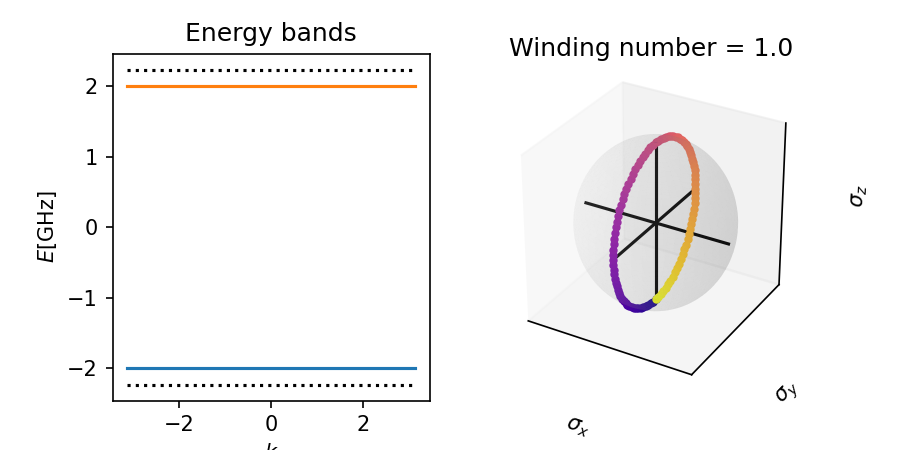

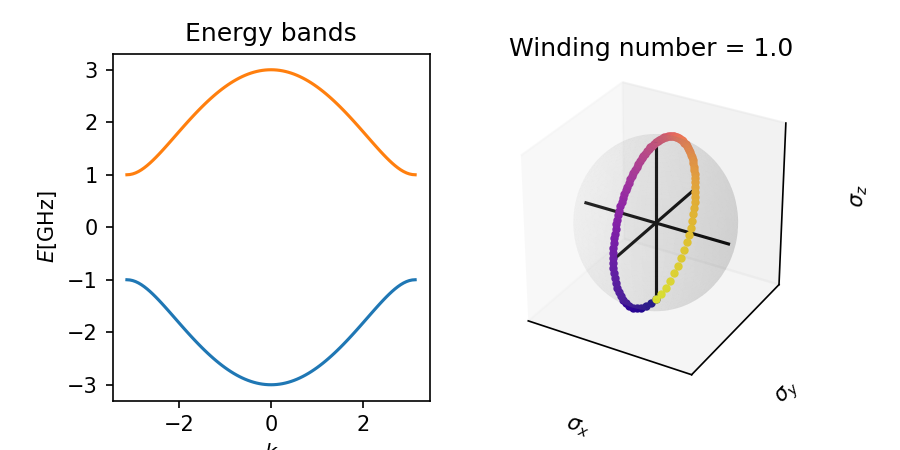

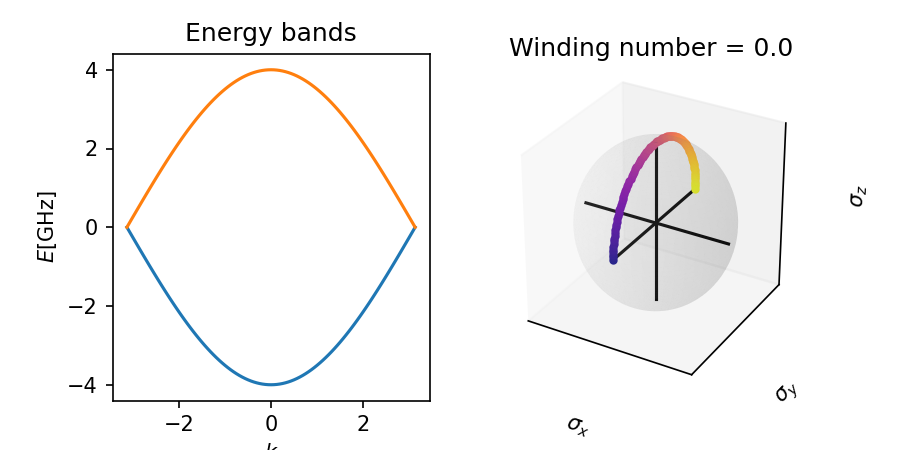

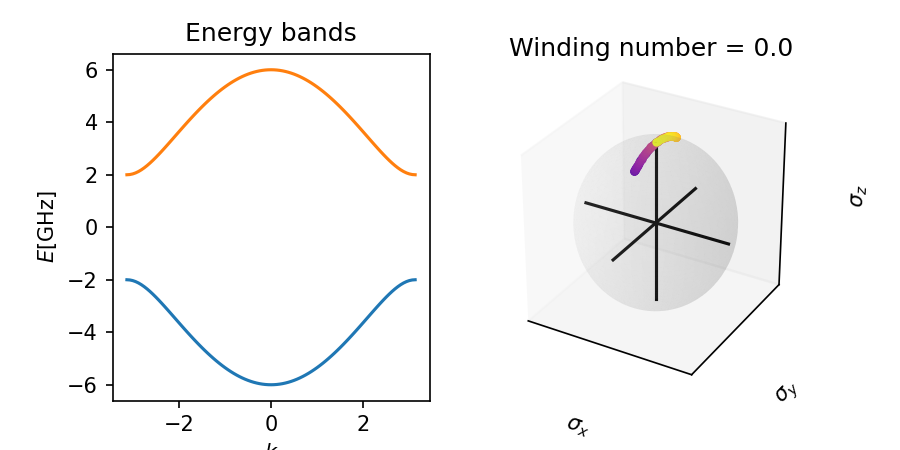

In [183]:
colors = figs.generate_colors_from_colormap(len(k_values), 'plasma')

for i, case in enumerate(cases): 
    fig = plt.figure(figsize=(6, 3), dpi=150)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Energy bands")
    ax2 = fig.add_subplot(1,2, 2, projection='3d')
    ax2.set_title(f"Winding number = {winding_number[i]}")
    
    ax = [ax1, ax2]
    
    #Energy bands
    ax[0].plot(k_values, E_k[i, :, 0])
    ax[0].plot(k_values, E_k[i, :, 1])
    ax[0].set_ylabel(r'$E$[GHz]')
    ax[0].set_xlabel('$k$')
    # ax.set_title(f'$\delta = {np.round(δ_values[δ_index],2)}$')
    # ax.set_ylim([-40,50])
    if i==0:
        ax[0].plot(k_values, E_flat_bands*np.ones_like(k_values),':k')
        ax[0].plot(k_values, -E_flat_bands*np.ones_like(k_values),':k')
        
        
    #Trajectory in bloch sphere
    ax[1].plot_surface(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.1)
    ax[1].plot([-1,1], [0,0], [0,0],'k')
    ax[1].plot([0,0],[-1,1],  [0,0],'k')
    ax[1].plot( [0,0], [0,0],[-1,1],'k')
    
    hx, hy, hz  = [ np.zeros(len(k_values)) for _ in range(3)]
    for j in range(len(k_values)):
        _, hx[j], hy[j], hz[j] =  sq_ext.decomposition_in_pauli_2x2(H_k[i,j])
        
    norm = np.sqrt(hx**2 + hy**2 + hz**2)
    hx /= norm
    hy /= norm
    hz /= norm
    
    for j in range(len(k_values)):
        ax[1].plot(hx[j], hy[j], hz[j],'.', color=colors[j])

    ax[1].set_xlabel(r'$\sigma_x$')
    ax[1].set_ylabel(r'$\sigma_y$')
    ax[1].set_zlabel(r'$\sigma_z$')
    ax[1].set_box_aspect([1,1,1])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_zticks([])
    
    # if i==2:
    #     fig.tight_layout()
    #     figs.export('Ek_Hk_dirac_zero.pdf', fig)
# fig.tight_layout()

In [52]:
plt.close('all')

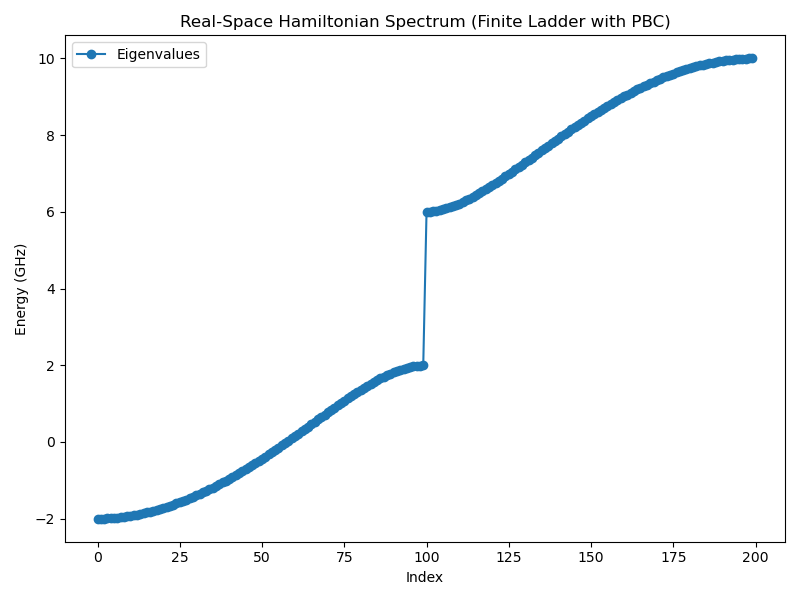

In [164]:
δ, g_Φ, g_c, g_q = cases[3]

# δ *=1.5
# g_Φ +=1
# g_c +=1

omega_c =  0 # Onsite frequency for mode a (resonator)
omega_q =  δ # Onsite frequency for mode a (resonator)

# Number of unit cells
N =100

# Total Hilbert space dimension: 2 modes per cell
dim = 2 * N

# Initialize the Hamiltonian matrix (complex valued)
H_real = np.zeros((dim, dim), dtype=np.complex128)

# Helper function to implement periodic boundary conditions:
def pbc(n, N):
    return n % N

# Loop over unit cells to build H_real
for n in range(N):
    # Basis ordering: index 2*n for mode a, index 2*n+1 for mode b at cell n.
    idx_a = 2 * n      # mode a in cell n
    idx_b = 2 * n + 1  # mode b in cell n

    # Onsite terms
    H_real[idx_a, idx_a] += omega_c
    H_real[idx_b, idx_b] += omega_q

    # Intra-cell (onsite) coupling between a and b (and its Hermitian conjugate)
    H_real[idx_a, idx_b] += g_Φ
    H_real[idx_b, idx_a] += g_Φ

    # Inter-cell couplings: couple cell n with cell n+1 (with periodic BC)
    # Determine indices for cell n+1 using periodic boundary conditions:
    n_next = pbc(n + 1, N)
    idx_a_next = 2 * n_next      # a in cell n+1
    idx_b_next = 2 * n_next      + 1  # b in cell n+1

    if n==N-1:
        continue
    # Coupling between adjacent a modes (resonators): g_c (real, + sign)
    H_real[idx_a, idx_a_next] += g_c
    H_real[idx_a_next, idx_a] += g_c

    # Coupling between adjacent b modes (qubits): g_q (real, - sign)
    H_real[idx_b, idx_b_next] += -g_q
    H_real[idx_b_next, idx_b] += -g_q

    # Cross-coupling: from b in cell n to a in cell n+1: -np.sqrt(g_c * g_q) 
    H_real[idx_b, idx_a_next] += -np.sqrt(g_c * g_q) 
    H_real[idx_a_next, idx_b] += -np.sqrt(g_c * g_q) 

    # Cross-coupling: from a in cell n to b in cell n+1: +np.sqrt(g_c * g_q) 
    H_real[idx_a, idx_b_next] += np.sqrt(g_c * g_q) 
    H_real[idx_b_next, idx_a] += np.sqrt(g_c * g_q) 


# Diagonalize the Hamiltonian
eigvals, eigvecs = np.linalg.eig(H_real)
eigvals = np.sort(np.real(eigvals))  # sorting eigenvalues

# Plot the eigenvalue spectrum
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(np.arange(dim), eigvals, 'o-', label='Eigenvalues')
ax.set_xlabel('Index')
ax.set_ylabel('Energy (GHz)')
ax.set_title('Real-Space Hamiltonian Spectrum (Finite Ladder with PBC)')
ax.legend()
fig.tight_layout()


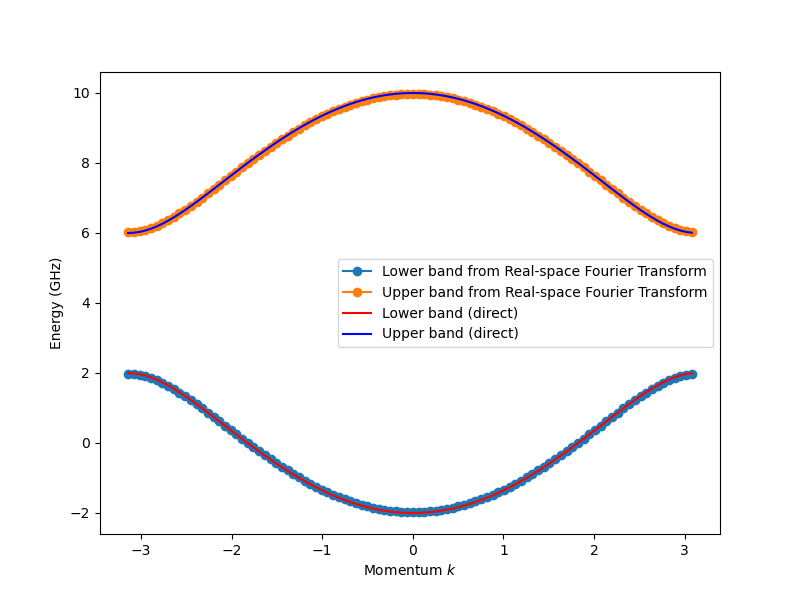

In [165]:
# Create the Fourier transform matrix F for the cell indices (N x N)
F = np.zeros((N, N), dtype=np.complex128)
for n in range(N):
    for m in range(N):
        k = 2 * np.pi * m / N  # allowed discrete momentum
        F[n, m] = np.exp(1j * k * n) / np.sqrt(N)

# Build the full Fourier transform matrix U for the 2N-dimensional space:
# U = F \otimes I_2
I2 = np.eye(2, dtype=np.complex128)
U = np.kron(F, I2)

# Transform the real-space Hamiltonian into momentum space
H_mom = U.conj().T @ H_real @ U

# Now, H_mom should be block-diagonal.
# Extract the 2x2 blocks for each momentum value:
Hk_blocks = np.zeros((N, 2, 2), dtype=np.complex128)
eigvals_mom = np.zeros((N, 2))
for m in range(N):
    # The block corresponding to momentum k = 2pi*m/N is:
    Hk_blocks[m] = H_mom[2*m:2*m+2, 2*m:2*m+2]
    eigvals = np.linalg.eigvals(Hk_blocks[m])
    eigvals_mom[m] = np.sort(np.real(eigvals)) #- np.mean(np.real(eigvals))

# Construct corresponding k values
k_vals = np.array([2*np.pi*m/N for m in range(N)])#-np.pi

# Plot the momentum-space bands from the block diagonalization
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(k_vals-np.pi, eigvals_mom[:, 0], 'o-', label='Lower band from Real-space Fourier Transform')
ax.plot(k_vals-np.pi, eigvals_mom[:, 1], 'o-', label='Upper band from Real-space Fourier Transform')
ax.set_xlabel('Momentum $k$')
ax.set_ylabel('Energy (GHz)')

# For comparison, we also construct the momentum-space Hamiltonian directly:
E_band1 = np.zeros(N)
E_band2 = np.zeros(N)
for m, k in enumerate(k_vals):
    M_k = np.array([[omega_c + 2*g_c*np.cos(k), g_Φ + 1j*2*np.sqrt(g_c * g_q) *np.sin(k)],
                    [g_Φ - 1j*2*np.sqrt(g_c * g_q) *np.sin(k), omega_q - 2*g_q*np.cos(k)]])
    # M_k = sq_ext.Hk_unit_cell_boson_ladder(δ, g_Φ, g_c, g_q, k)

    eigvals = np.linalg.eigvals(M_k)
    eigvals = np.sort(np.real(eigvals))
    E_band1[m] = eigvals[0]
    E_band2[m] = eigvals[1]

ax.plot(k_vals-np.pi, E_band1, 'r-', label='Lower band (direct)')
ax.plot(k_vals-np.pi, E_band2, 'b-', label='Upper band (direct)')

ax.legend()

In [166]:
# Assume you already have H_real and N, dim, etc., from your existing code.

# 1) Diagonalize H_real
eigvals_real, eigvecs_real = np.linalg.eig(H_real)
eigvals_real = np.real(eigvals_real)
idx_sort = np.argsort(eigvals_real)
eigvals_sorted = eigvals_real[idx_sort]
eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors

Chosen eigenvalue ~ 6.00189625744284


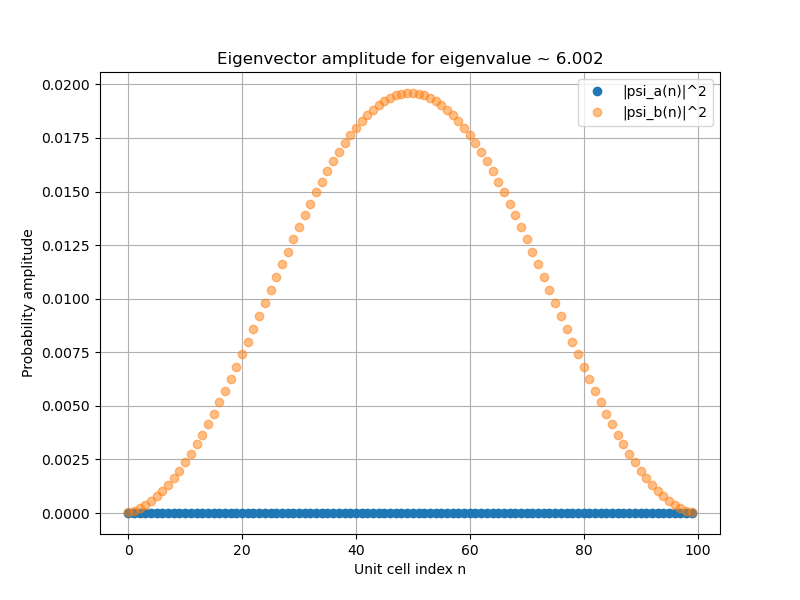

In [167]:

# 2) Pick an eigenstate index, for example the middle of the spectrum if there's a gap
mid_index = dim // 2# or any other index of interest
# mid_index = 3 # or any other index of interest
eigenvalue_of_interest = eigvals_sorted[mid_index]
eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column

print(f"Chosen eigenvalue ~ {eigenvalue_of_interest}")

# 3) Separate amplitude for each site, recall basis: 2n -> a_n, 2n+1 -> b_n
amplitudes_a = []
amplitudes_b = []
for n in range(N):
    amp_a_n = eigenvector_of_interest[2*n]
    amp_b_n = eigenvector_of_interest[2*n+1]
    amplitudes_a.append(np.abs(amp_a_n)**2)
    amplitudes_b.append(np.abs(amp_b_n)**2)

# 4) Plot to see if it is localized near boundaries
sites = np.arange(N)  # site index
plt.figure(figsize=(8,6))
plt.plot(sites, amplitudes_a, 'o', label='|psi_a(n)|^2')
plt.plot(sites, amplitudes_b, 'o', label='|psi_b(n)|^2', alpha=0.5)
plt.xlabel('Unit cell index n')
plt.ylabel('Probability amplitude')
plt.title(f'Eigenvector amplitude for eigenvalue ~ {eigenvalue_of_interest:.3f}')
plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()


In [184]:
E_real_vs_case = []
Amp_real_vs_case = []

for [δ, g_Φ, g_c, g_q] in cases:

    omega_c =  0 # Onsite frequency for mode a (resonator)
    omega_q =  δ # Onsite frequency for mode a (resonator)
    N=100
    dim=2*N
    
    H_real = H_real_ladder(omega_c,omega_q, g_Φ,g_c,g_q, N=100)
    
    eigvals_real, eigvecs_real = np.linalg.eig(H_real)
    eigvals_real = np.real(eigvals_real)
    idx_sort = np.argsort(eigvals_real)
    eigvals_sorted = eigvals_real[idx_sort]
    eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors
    
    E_real_vs_case.append(eigvals_sorted)
    
    mid_index = dim // 2
    eigenvalue_of_interest = eigvals_sorted[mid_index]
    eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column
    
    amplitudes_a = []
    amplitudes_b = []
    for n in range(N):
        amp_a_n = eigenvector_of_interest[2*n]
        amp_b_n = eigenvector_of_interest[2*n+1]
        amplitudes_a.append(np.abs(amp_a_n)**2)
        amplitudes_b.append(np.abs(amp_b_n)**2)
    
    Amp_real_vs_case.append((amplitudes_a,amplitudes_b))
    
    # # 4) Plot to see if it is localized near boundaries
    # sites = np.arange(N)  # site index
    # plt.figure(figsize=(8,6))
    # plt.plot(sites, amplitudes_a, 'o', label='|psi_a(n)|^2')
    # plt.plot(sites, amplitudes_b, 'o', label='|psi_b(n)|^2', alpha=0.5)
    # plt.xlabel('Unit cell index n')
    # plt.ylabel('Probability amplitude')
    # plt.title(f'Eigenvector amplitude for eigenvalue ~ {eigenvalue_of_interest:.3f}')
    # plt.legend()
    # # plt.yscale('log')
    # plt.grid(True)
    # plt.show()


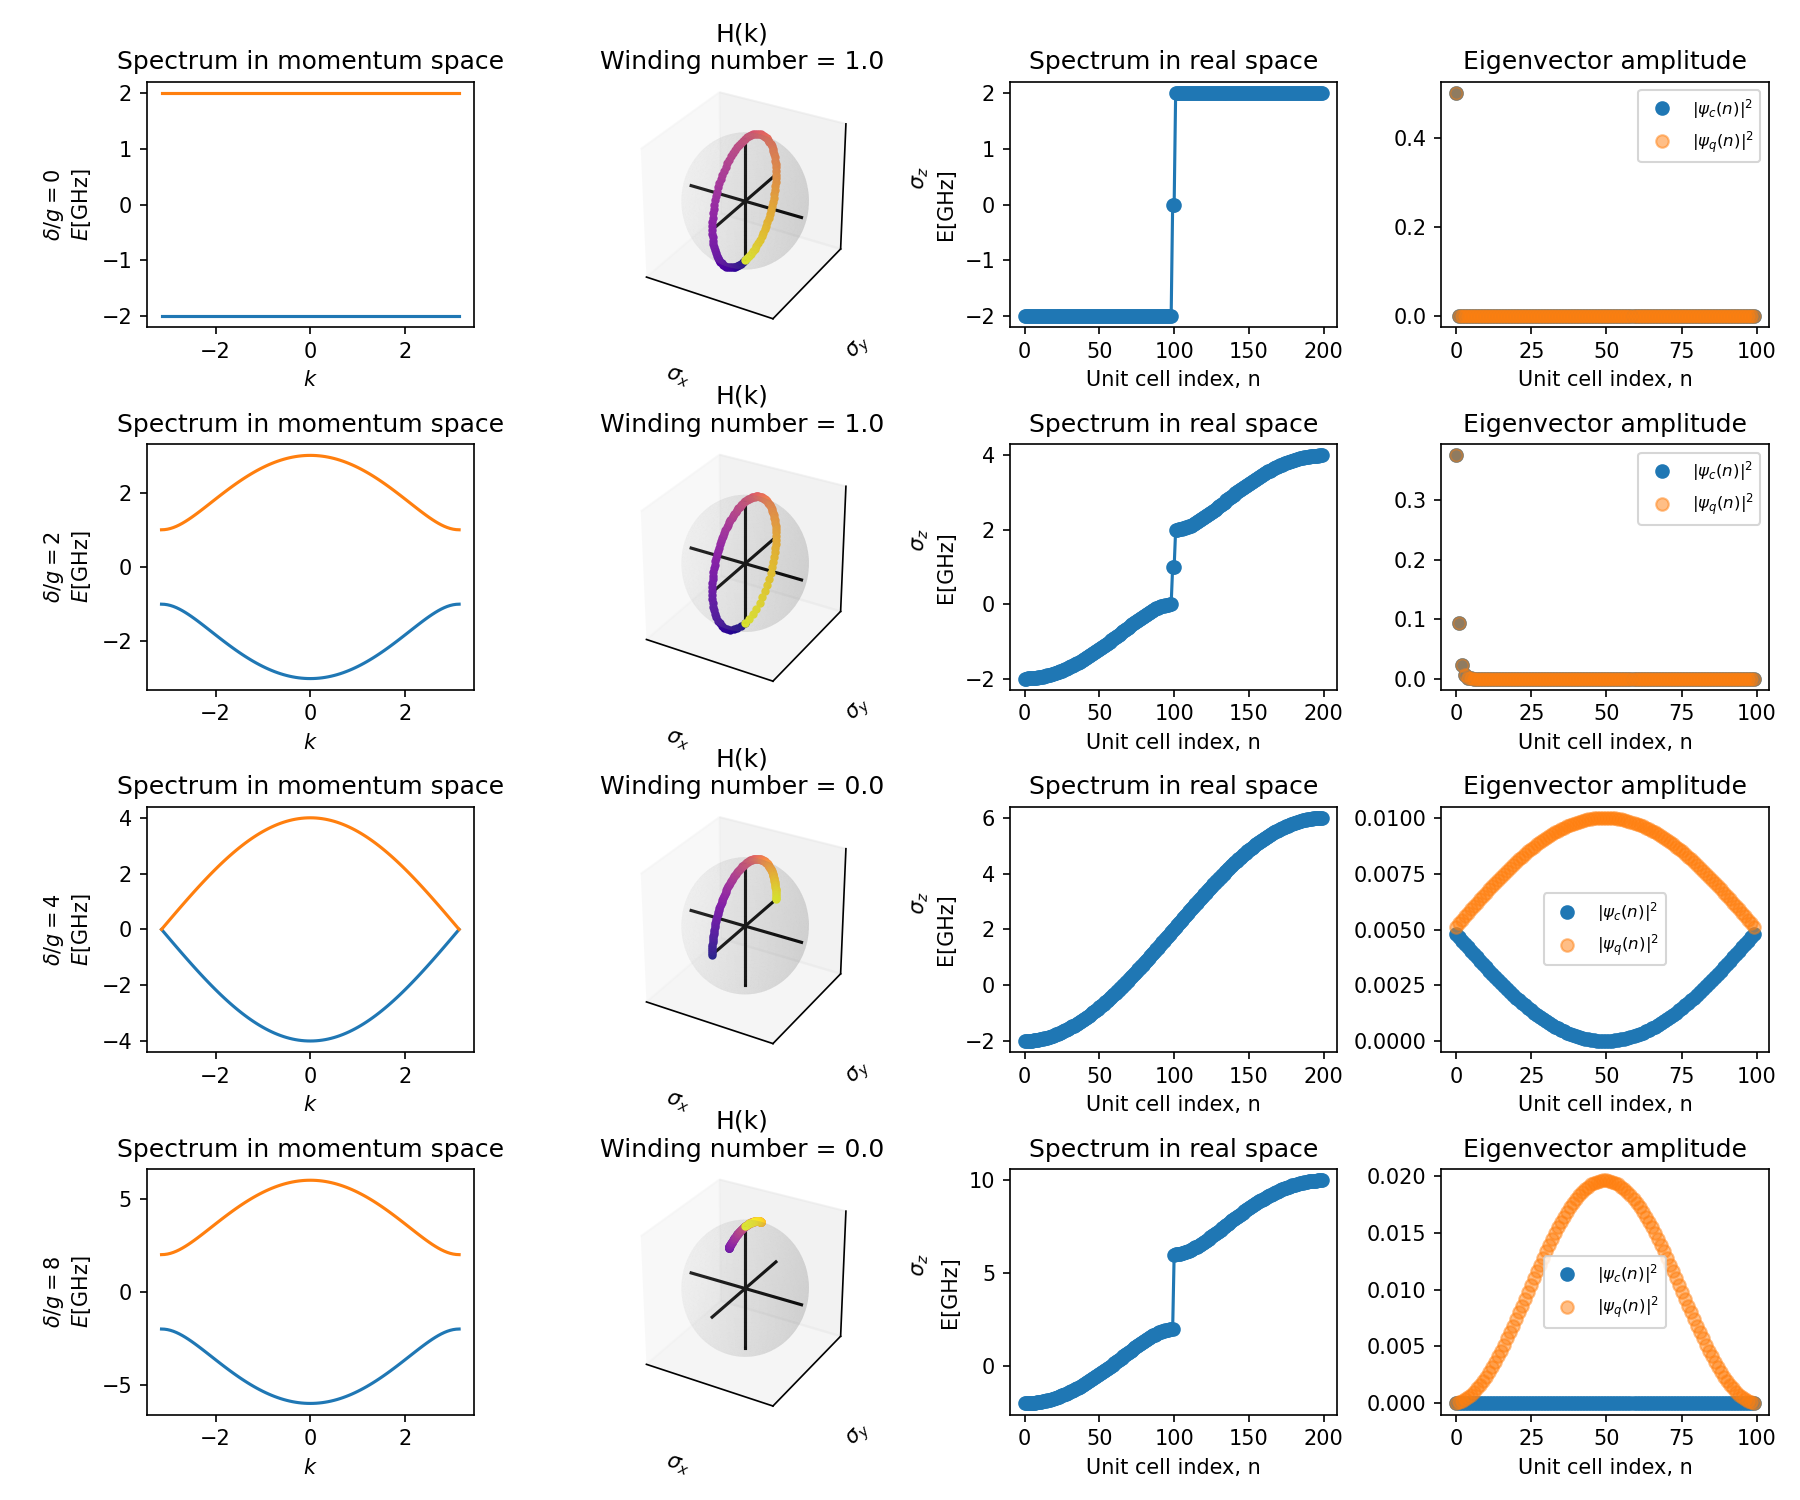

In [212]:
colors = figs.generate_colors_from_colormap(len(k_values), 'plasma')
fig = plt.figure(figsize=(12, 10), dpi=150)

nc = len(cases)
for i, case in enumerate(cases): 
    
    base = i * 4
    
    ax1 = fig.add_subplot(nc , 4, base+1)
    ax1.set_title("Spectrum in momentum space")
    ax2 = fig.add_subplot(nc,4, base+2, projection='3d')
    ax2.set_title('H(k)' +'\n' + rf'Winding number = {winding_number[i]}')
    ax3 = fig.add_subplot(nc , 4, base+3)
    ax3.set_title("Spectrum in real space")
    ax4 = fig.add_subplot(nc , 4, base+4)
    ax4.set_title("Eigenvector amplitude")
    
    ax = [ax1, ax2, ax3, ax4]
    
    #Energy bands
    ax[0].plot(k_values, E_k[i, :, 0])
    ax[0].plot(k_values, E_k[i, :, 1])
    ax[0].set_ylabel(cases_titles[i]+'\n'+r'$E$[GHz]')
    ax[0].set_xlabel('$k$')
    # ax.set_title(f'$\delta = {np.round(δ_values[δ_index],2)}$')
    # ax.set_ylim([-40,50])
    # if i==0:
    #     ax[0].plot(k_values, E_flat_bands*np.ones_like(k_values),':k')
    #     ax[0].plot(k_values, -E_flat_bands*np.ones_like(k_values),':k')
        
    #Trajectory in bloch sphere
    ax[1].plot_surface(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.1)
    ax[1].plot([-1,1], [0,0], [0,0],'k')
    ax[1].plot([0,0],[-1,1],  [0,0],'k')
    ax[1].plot( [0,0], [0,0],[-1,1],'k')
    
    hx, hy, hz  = [ np.zeros(len(k_values)) for _ in range(3)]
    for j in range(len(k_values)):
        _, hx[j], hy[j], hz[j] =  sq_ext.decomposition_in_pauli_2x2(H_k[i,j])
        
    norm = np.sqrt(hx**2 + hy**2 + hz**2)
    hx /= norm
    hy /= norm
    hz /= norm
    
    for j in range(len(k_values)):
        ax[1].plot(hx[j], hy[j], hz[j],'.', color=colors[j])

    ax[1].set_xlabel(r'$\sigma_x$')
    ax[1].set_ylabel(r'$\sigma_y$')
    ax[1].set_zlabel(r'$\sigma_z$')
    ax[1].set_box_aspect([1,1,1])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_zticks([])
    
    ax[2].plot(np.arange(dim), E_real_vs_case[i], 'o-', label='Eigenvalues')
    ax[2].set_xlabel('Unit cell index, n')
    ax[2].set_ylabel('E[GHz]')
    
    ax[3] .plot(sites, Amp_real_vs_case[i][0], 'o', label=r'$|\psi_c(n)|^2$')
    ax[3] .plot(sites, Amp_real_vs_case[i][1], 'o', label=r'$|\psi_q(n)|^2$', alpha=0.5)
    ax[3].legend(fontsize=8)
    ax[3].set_xlabel('Unit cell index, n')
    
fig.tight_layout()

figs.export('topological_clasification_ladder.pdf', fig)

In [191]:
plt.close('all')